# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


### 3.4 Basic statistics

In [3]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [4]:
sum2 = lambda a, b: a + b
num_rating_per_user = ratings.map(lambda obj : (obj['userId'], 1)).reduceByKey(sum2).sortByKey().values().collect()
num_rating_per_movie = ratings.map(lambda obj : (obj['movieId'], 1)).reduceByKey(sum2).sortByKey().values().collect()

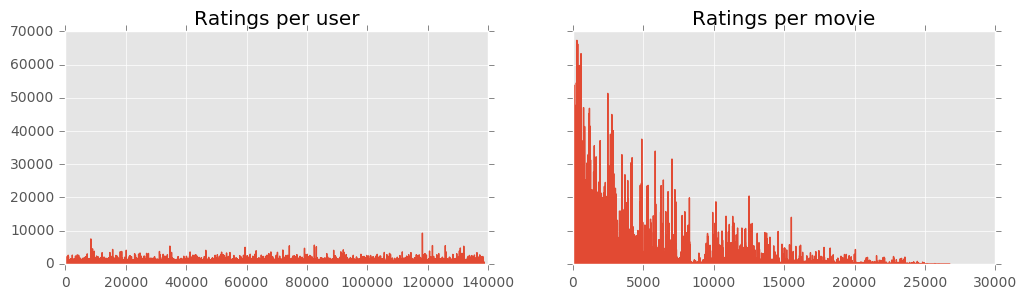

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
ax1.plot(num_rating_per_user)
ax1.set_title("Ratings per user")
ax2.plot(num_rating_per_movie)
ax2.set_title("Ratings per movie")

We can see that the ratings per user is generally balanced, which is not the case for the ratings per movie. Some movies have much more ratings than others.

### 3.5 Partitioning the dataset

In [6]:
#Couldnt read file so I did it manually
my_ratings = sc.parallelize([
    {"movieId": 1, "rating": 5, "timestamp": 1491989698, "userId": 138494},
    {"movieId": 780, "rating": 3, "timestamp": 1491989704, "userId": 138494},
    {"movieId": 590, "rating": 4, "timestamp": 1491989707, "userId": 138494},
    {"movieId": 1210, "rating": 5, "timestamp": 1491989709, "userId": 138494},
    {"movieId": 648, "rating": 3, "timestamp": 1491989712, "userId": 138494},
    {"movieId": 344, "rating": 3, "timestamp": 1491989722, "userId": 138494},
    {"movieId": 165, "rating": 3, "timestamp": 1491989727, "userId": 138494},
    {"movieId": 153, "rating": 2, "timestamp": 1491989731, "userId": 138494},
    {"movieId": 597, "rating": 1, "timestamp": 1491989734, "userId": 138494},
    {"movieId": 1580, "rating": 3, "timestamp": 1491989743, "userId": 138494},
    {"movieId": 231, "rating": 2, "timestamp": 1491989750, "userId": 138494},
])

In [7]:
#Add my ratings
complete_ratings = ratings.union(my_ratings)

In [8]:
#Split the data set using the last digit of time stamp (80%-20%)
less_than_eight = lambda x: x['timestamp'] %10 < 8
more_than_eight = lambda x: not less_than_eight(x)

training_data = complete_ratings.filter(less_than_eight).cache()
validation_data = complete_ratings.filter(more_than_eight)

## Baseline Recommender System

### 3.6 Baseline model

In [9]:
global_average = training_data.map(lambda j: j['rating']).mean()
global_average

3.52551614643662

In [10]:
def sum_tuples(tup1, tup2):
    """
    Performs the element-wise sum the two tuple arguments
    """
    return (tup1[0] + tup2[0] , tup1[1] + tup2[1])

In [11]:
alphas = training_data.map(lambda j: (j['userId'], (j['rating'] - global_average, 1)))\
                      .reduceByKey(sum_tuples)\
                      .mapValues(lambda tup: tup[0] / tup[1]).cache()

In [12]:
NP = training_data.getNumPartitions()

In [13]:
# seqOp accumulates the sum of r_um - mu - alpha_u and the count of ratings per movie
seqOp = lambda acc, tr: (acc[0] + tr[0] - tr[1] - global_average, acc[1] + 1)

with_alpha = training_data.map(lambda j: (j['userId'],  (j['movieId'], j['rating'])))\
                          .join(alphas)\
                          .map(lambda t: (t[1][0][0], (t[1][0][1], t[1][1]))) #(movieId, (rating, alpha))

betas = with_alpha.aggregateByKey((0,0), seqOp, sum_tuples, numPartitions=NP)\
                  .mapValues(lambda t: t[0] / t[1]).cache()

To fill in the blanks of missing user/movie ratings we took the average of alphas and betas

In [14]:
default_alpha = alphas.values().mean()
default_beta = betas.values().mean()
(default_alpha, default_beta)

(0.10166146018547202, -0.2045078615587813)

In [15]:
placeholder = validation_data.map(lambda j: (j['userId'], (j['movieId'], 1)))

def fix_empty_users(t):
    """
    Replaces missing alphas with default value and converts to format:
    (movieId, (userId, alpha))
    """
    alpha = t[1][1] if not t[1][1] == None else default_alpha
    return (t[1][0][0], (t[0], alpha))

with_alphas = placeholder.leftOuterJoin(alphas, numPartitions=NP)\
                         .map(fix_empty_users)

def fix_empty_movies(t):
    """
    Replaces missing betas with default value and converts to format:
    ((userId, movieId), (alpha, beta))
    """
    beta = default_beta if t[1][1] is None else t[1][1]
    return ((t[1][0][0], t[0]) , (t[1][0][1], beta))

user_movie_to_biases = with_alphas.leftOuterJoin(betas, numPartitions=NP)\
                                 .map(fix_empty_movies)

# Computes rank for one user/item pair given user and movie biases
compute_single_rank = lambda biases: biases[0] + biases[1] + global_average

baseline_scores = user_movie_to_biases.map(lambda t: (t[0][0], t[0][1], compute_single_rank(t[1])))

### 3.7 Evaluation

In [16]:
val = validation_data.map(lambda j: ((j['userId'], j['movieId']), j['rating']))

In [17]:
import math
def error(rdd):
    tmp = rdd.map(lambda t: ((t[0], t[1]), t[2])) # ((userId, movieId), rating)
    mixed = val.join(tmp)
    by_user = mixed.map(lambda t: (t[0][0], (t[1][1], t[1][0]))) # (userId, (computedScore, scoreInValidation))
    square = lambda x: x*x
    # seqOp accumulates the sum of the squares of the differences of approximated and real rank
    # per user and the number of recommendations by that user
    seqOp = lambda acc, t: (acc[0] + square(t[0] - t[1]) , acc[1] + 1)
    sum, user_count = by_user.aggregateByKey((0, 0), seqOp, sum_tuples)\
                            .map(lambda t: (math.sqrt(t[1][0] / t[1][1]), 1))\
                            .reduce(sum_tuples)
    return sum / user_count

Error obtained with baseline predictor:

In [18]:
baseline_error = error(baseline_scores)
baseline_error

0.8669177244805789

## Matrix Factorization Model

The rank is related to the number of hidden factors in the data. Choosing a rank too small may lead to underfitting (but provides better performances) while a bigger value may lead to overfitting (and will run slower).

In [19]:
from pyspark.mllib.recommendation import ALS

### 3.8 Regularization

In [20]:
ratings = training_data.map(lambda j: (j['userId'], j['movieId'], j['rating']))

In [21]:
# Learning a model
model = ALS.train(ratings, rank=10, iterations=10, lambda_=10**(-4))

In [22]:
als_scores = model.predictAll(validation_data.map(lambda j: (j['userId'], j['movieId'])))

In [23]:
als_scores.take(3)

[Rating(user=18624, product=541, rating=4.759543758010464),
 Rating(user=18624, product=117533, rating=3.4736118526637334),
 Rating(user=18624, product=1077, rating=3.875287610447506)]

In [24]:
error(als_scores)

0.8836219911406281

The baseline predictor was more accurate. This is due to the fact that our model uses a lambda (0.0001) much too small which leads to underfitting

In [25]:
# Change lambda now to 10.0
als_scores = ALS.train(ratings, rank=10, iterations=10, lambda_=10.0)\
            .predictAll(validation_data.map(lambda j: (j['userId'], j['movieId'])))

In [26]:
error(als_scores)

3.7462518298357943

The error is 4 times bigger!

This is due to the fact that we are trying to minimize the cost function and the regularizer: $\underset{\theta}{\min} f_\theta(x) + \lambda g(\theta)$. $\lambda$ too large leads to overgeneralization while $\lambda$ leads to overfitting. We have to choose a better $\lambda$!

In [20]:
# Find the value that minimizes the error
logspace = np.logspace(-6, 1, num=10)
i = 0
err = 10
evaluate_als = lambda lam: error(ALS.train(ratings, rank=10, iterations=10, lambda_=lam)\
                                    .predictAll(validation_data.map(lambda j: (j['userId'], j['movieId']))))
for lambda_ in logspace:
    err = evaluate_als(lambda_)
    print('Lambda =', lambda_,'-> error =', err)
    i += 1

Lambda = 1e-06 -> error = 0.9742331742502927
Lambda = 5.99484250319e-06 -> error = 0.9445541008977902
Lambda = 3.5938136638e-05 -> error = 0.9050133114464965
Lambda = 0.000215443469003 -> error = 0.8739900312949199
Lambda = 0.00129154966501 -> error = 0.8553959634941466
Lambda = 0.00774263682681 -> error = 0.8409551235972661
Lambda = 0.0464158883361 -> error = 0.8066278621683064
Lambda = 0.278255940221 -> error = 0.8899771696305591
Lambda = 1.6681005372 -> error = 1.8942200711599115
Lambda = 10.0 -> error = 3.7462518298357894


In [24]:
space = np.linspace(0.008, 0.06, num=30, endpoint=True)

for lambda_ in space:
    err = evaluate_als(lambda_)
    print('Lambda =', lambda_,'-> error =', err)

Lambda = 0.008 -> error = 0.8386333221899025
Lambda = 0.00979310344828 -> error = 0.8354929443233008
Lambda = 0.0115862068966 -> error = 0.8333807202176128
Lambda = 0.0133793103448 -> error = 0.8297997744481613
Lambda = 0.0151724137931 -> error = 0.8265318145079906
Lambda = 0.0169655172414 -> error = 0.8257533179446314
Lambda = 0.0187586206897 -> error = 0.8248588219635358
Lambda = 0.0205517241379 -> error = 0.8203681765757553
Lambda = 0.0223448275862 -> error = 0.8173285962537548
Lambda = 0.0241379310345 -> error = 0.8152874304493991
Lambda = 0.0259310344828 -> error = 0.8108441434820374
Lambda = 0.027724137931 -> error = 0.811554349896495
Lambda = 0.0295172413793 -> error = 0.8127074129069494
Lambda = 0.0313103448276 -> error = 0.8101553230986321
Lambda = 0.0331034482759 -> error = 0.8060689040609152
Lambda = 0.0348965517241 -> error = 0.809024540425495
Lambda = 0.0366896551724 -> error = 0.8085968097720054
Lambda = 0.0384827586207 -> error = 0.8096395978135982
Lambda = 0.04027586206

We can minimize the validation error with *lambda = 0.0582068965517*, the gain over the baseline predictor is *0.06719667589*. This predictor has much better results.

### 3.9 Recommendation

In [27]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2
titles = sc.textFile("/ix/ml-20m/movies.txt")\
           .map(json.loads)\
           .map(lambda j: (j['movieId'], j['title']))\
           .collectAsMap()

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [28]:
def to_ids(recommendations):
    return [tup[1] for tup in recommendations]

def print_titles(id_list):
    for ids in id_list:
        print(titles[ids])

In [29]:
model = ALS.train(ratings, rank=10, iterations=10, lambda_=0.0582068965517)

Recommending products to user *123*

In [30]:
rec1 = model.recommendProducts(123, 10)
print_titles(to_ids(rec1))

Jim Jefferies: Alcoholocaust (2010)
Carmina and Amen (Carmina y amén) (2014)
Habit (1995)
Shoppen (2006) 
My Life as McDull (Mak dau goo si) (2001)
Hamoun (1990)
Welcome (2009)
Kippur (2000)
Question of Silence, A (De stilte rond Christine M.) (1982)
Karthik Calling Karthik (2010)


Recommending products to me

In [31]:
rec2 = model.recommendProducts(138494, 10)
print_titles(to_ids(rec2))

Eve and the Fire Horse (2005)
Nine Lives of Tomas Katz, The (2000)
Chameleon (Kaméleon) (2008)
Bill Burr: Why Do I Do This? (2008)
Misérables, Les (1934)
Craig Ferguson: A Wee Bit o' Revolution (2009)
Day of Anger (I giorni dell'ira) (1967)
Tom Segura: Completely Normal (2014)
Big Snit, The (1985)
Code Name Coq Rouge (1989)


I'm not sure I would recommend our recommender system ;)

### 3.10 Visualisation

In [47]:
import pickle

In [48]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")

movies = sorted(selected_movies, key=lambda x: x[0])
movies_ids = {movie[0] for movie in movies}

In [73]:
selected_ratings = ratings.filter(lambda x : x[1] in movies_ids)

In [50]:
evaluate_als_2 = lambda lam: error(ALS.train(selected_ratings, rank=2, iterations=10, lambda_=lam)\
                                      .predictAll(validation_data.map(lambda j: (j['userId'], j['movieId']))))

In [81]:
evaluate_als_2(0.07)

0.7809064002986739

Here the error is smaller if we pick a bigger lambda than we did before.

In [86]:
s_model = ALS.train(selected_ratings, rank=2, iterations=10, lambda_=0.07)

In [87]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [88]:
movie_features = s_model.productFeatures()
id_to_title = {t[0]: t[1] for t in movies}
id_to_tomato_score = {t[0]: t[2] for t in movies}
data = movie_features.map(lambda x: (x[1][0], x[1][1], id_to_title[x[0]], id_to_tomato_score[x[0]]))\
                     .collect()

In [92]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "name": [x[2] for x in data],
        "score": [x[3] for x in data],
        "color": [val2rgb(x[3]) for x in data],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("Score", "@score"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

Althoug it is not very clear, probably due to the fact that we only compute over 37 movies, we can see some similarity between regrouped points on the x axis. On the far left [-2.2 ; -1.8] are comedies. We then shift to dramas of different kind [-1.7 ; -0.9]. After that come multiple science-fiction movies [-1 ; -0.3] and finaly the last batch (althought this one is not as clear as the other) regroups action/thriller movies [-0,2 ; 0.5].

The node color is based on the movies rating from rottentomatoes.